# Complete file

## Making Base agent and Base Environment


# Agent

In [1]:
#agent
#!/usr/bin/env python

"""An abstract class that specifies the Agent API for RL-Glue-py.
"""

from __future__ import print_function
from abc import ABCMeta, abstractmethod


class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """


# Environment

In [2]:
#environment
#!/usr/bin/env python

"""Abstract environment base class for RL-Glue-py.
"""

from __future__ import print_function

from abc import ABCMeta, abstractmethod


class BaseEnvironment:
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)

    @abstractmethod
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

    @abstractmethod
    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

    @abstractmethod
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

    @abstractmethod
    def env_cleanup(self):
        """Cleanup done after the environment ends"""

    @abstractmethod
    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message: the message passed to the environment

        Returns:
            the response (or answer) to the message
        """

# RL Glue

In [3]:
#rl glue
#!/usr/bin/env python

"""Glues together an experiment, agent, and environment.
"""

from __future__ import print_function


class RLGlue:
    """RLGlue class

    args:
        env_name (string): the name of the module where the Environment class can be found
        agent_name (string): the name of the module where the Agent class can be found
    """

    def __init__(self, env_class, agent_class):
        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None

    def rl_init(self, agent_init_info={}, env_init_info={}):
        """Initial method called when RLGlue experiment is created"""
        self.environment.env_init(env_init_info)
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0

    def rl_start(self, agent_start_info={}, env_start_info={}):
        """Starts RLGlue experiment

        Returns:
            tuple: (state, action)
        """

        last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(last_state)

        observation = (last_state, self.last_action)

        return observation

    def rl_agent_start(self, observation):
        """Starts the agent.

        Args:
            observation: The first observation from the environment

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_start(observation)

    def rl_agent_step(self, reward, observation):
        """Step taken by the agent

        Args:
            reward (float): the last reward the agent received for taking the
                last action.
            observation : the state observation the agent receives from the
                environment.

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_step(reward, observation)

    def rl_agent_end(self, reward):
        """Run when the agent terminates

        Args:
            reward (float): the reward the agent received when terminating
        """
        self.agent.agent_end(reward)

    def rl_env_start(self):
        """Starts RL-Glue environment.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination
        """
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.env_start()

        return this_observation

    def rl_env_step(self, action):
        """Step taken by the environment based on action from agent

        Args:
            action: Action taken by agent.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination.
        """
        ro = self.environment.env_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    def rl_step(self):
        """Step taken by RLGlue, takes environment step and either step or
            end by agent.

        Returns:
            (float, state, action, Boolean): reward, last state observation,
                last action, boolean indicating termination
        """

        (reward, last_state, term) = self.environment.env_step(self.last_action)

        self.total_reward += reward

        if term:
            self.num_episodes += 1
            self.agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.agent_step(reward, last_state)
            roat = (reward, last_state, self.last_action, term)

        return roat

    def rl_cleanup(self):
        """Cleanup done at end of experiment."""
        self.environment.env_cleanup()
        self.agent.agent_cleanup()

    def rl_agent_message(self, message):
        """Message passed to communicate with agent during experiment

        Args:
            message: the message (or question) to send to the agent

        Returns:
            The message back (or answer) from the agent

        """

        return self.agent.agent_message(message)

    def rl_env_message(self, message):
        """Message passed to communicate with environment during experiment

        Args:
            message: the message (or question) to send to the environment

        Returns:
            The message back (or answer) from the environment

        """
        return self.environment.env_message(message)

    def rl_episode(self, max_steps_this_episode):
        """Runs an RLGlue episode

        Args:
            max_steps_this_episode (Int): the maximum steps for the experiment to run in an episode

        Returns:
            Boolean: if the episode should terminate
        """
        is_terminal = False

        self.rl_start()

        while (not is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            rl_step_result = self.rl_step()
            is_terminal = rl_step_result[3]

        return is_terminal

    def rl_return(self):
        """The total reward

        Returns:
            float: the total reward
        """
        return self.total_reward

    def rl_num_steps(self):
        """The total number of steps taken

        Returns:
            Int: the total number of steps taken
        """
        return self.num_steps

    def rl_num_episodes(self):
        """The number of episodes

        Returns
            Int: the total number of episodes

        """
        return self.num_episodes

# Sub-Class of Agent: Main Agent

In [4]:
# main agent
import numpy as np

class Agent(BaseAgent):
    """agent does *no* learning, selects action 0 always"""
    def __init__(self):
        self.last_action = None
        self.num_actions = None
        self.q_values = None
        self.step_size = None
        self.epsilon = None
        self.initial_value = 0.0
        self.arm_count = [0.0 for _ in range(10)]

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""

        # if "actions" in agent_info:
        #     self.num_actions = agent_info["actions"]

        # if "state_array" in agent_info:
        #     self.q_values = agent_info["state_array"]

        self.num_actions = agent_info.get("num_actions", 2)
        self.initial_value = agent_info.get("initial_value", 0.0)
        self.q_values = np.ones(agent_info.get("num_actions", 2)) * self.initial_value
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.0)

        self.last_action = 0

    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.last_action = np.random.choice(self.num_actions)  # set first action to 0

        return self.last_action

    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # local_action = 0  # choose the action here
        self.last_action = np.random.choice(self.num_actions)

        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        pass

    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

# Sub-Class of Environment: Test_Environment

In [5]:
#test_environment
import numpy as np

class test_Environment(BaseEnvironment):
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    actions = [0]

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)
        self.count = 0
        self.arms = []

    def env_init(self, agent_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

        self.arms = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0] #[np.random.normal(0.0, 1.0) for _ in range(10)]
        local_observation = 0  # An empty NumPy array

        self.reward_obs_term = (0.0, local_observation, False)


    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """
        return self.reward_obs_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

        # if action == 0:
        #     if np.random.random() < 0.2:
        #         reward = 14
        #     else:
        #         reward = 6

        # if action == 1:
        #     reward = np.random.choice(range(10,14))

        # if action == 2:
        #     if np.random.random() < 0.8:
        #         reward = 174
        #     else:
        #         reward = 7

        # reward = np.random.normal(self.arms[action], 1.0)
        reward = self.arms[action]

        obs = self.reward_obs_term[1]

        self.reward_obs_term = (reward, obs, False)

        return self.reward_obs_term

    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        pass

    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message (string): the message passed to the environment

        Returns:
            string: the response (or answer) to the message
        """
        if message == "what is the current reward?":
            return "{}".format(self.reward_obs_term[0])

        # else
        return "I don't know how to respond to your message"

# Sub-Class of Environment: Ten-Arm-Bandit Environment

In [6]:
#ten_arm_env
class ten_arm_env_Environment(BaseEnvironment):
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    actions = [0]

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)
        self.count = 0
        self.arms = []
        self.seed = None

    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

        self.arms = np.random.randn(10)#[np.random.normal(0.0, 1.0) for _ in range(10)]
        local_observation = 0  # An empty NumPy array

        self.reward_obs_term = (0.0, local_observation, False)


    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """
        return self.reward_obs_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

        # if action == 0:
        #     if np.random.random() < 0.2:
        #         reward = 14
        #     else:
        #         reward = 6

        # if action == 1:
        #     reward = np.random.choice(range(10,14))

        # if action == 2:
        #     if np.random.random() < 0.8:
        #         reward = 174
        #     else:
        #         reward = 7

        # reward = np.random.normal(self.arms[action], 1.0)

        reward = self.arms[action] + np.random.randn()

        obs = self.reward_obs_term[1]

        self.reward_obs_term = (reward, obs, False)

        return self.reward_obs_term

    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        pass

    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message (string): the message passed to the environment

        Returns:
            string: the response (or answer) to the message
        """
        if message == "what is the current reward?":
            return "{}".format(self.reward_obs_term[0])

        # else
        return "I don't know how to respond to your message"

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [8]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        # YOUR CODE HERE
        a = 0;
        if(q_values[i]> top_value):
            top_value = q_values[i]
            a = i
            ties = []
        if(q_values[i] == top_value):
            ties.append(i)
            a = 0
        
        #raise NotImplementedError()
    if(a != 0):
        return a
    x = np.random.choice(ties)
    return x

# Sub-Class of Agent: Greedy Agent

In [9]:
class GreedyAgent(Agent):
    def agent_step(self, reward, observation=None):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        #self.q_values : An array with what the agent believes each of the values of the arm are.
        #self.arm_count : An array with a count of the number of times each arm has been pulled.
        #self.last_action : The action that the agent took on the previous time step
        #######################
        
        # Update Q values Hint: Look at the algorithm in section 2.4 of the textbook.
        # increment the counter in self.arm_count for the action from the previous time step
        # update the step size using self.arm_count
        # update self.q_values for the action from the previous time step
        
        # YOUR CODE HERE
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action] = self.q_values[self.last_action] + (reward - self.q_values[self.last_action])/self.arm_count[self.last_action] 
        
        
        # current action = ? # Use the argmax function you created above
        current_action = argmax(self.q_values)
        
    
        self.last_action = current_action
        
        return current_action

# Greedy Agent average return in 10 Arm Bandit Environment

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 40.87it/s]


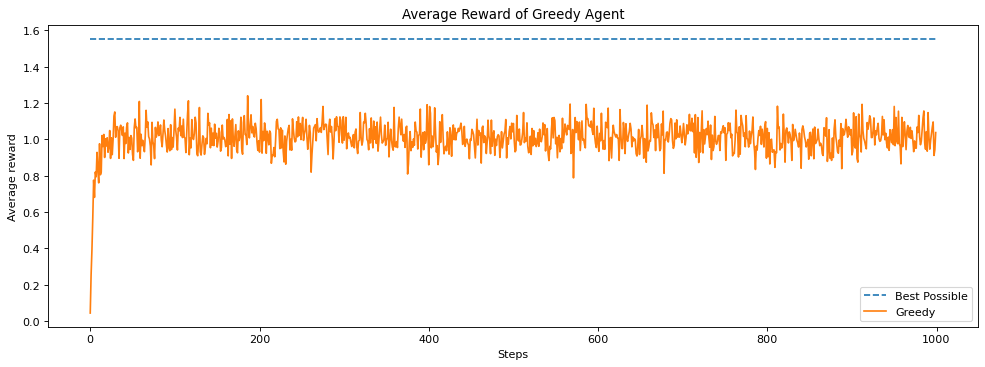

In [10]:
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env_Environment                 # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

rewards = np.zeros((num_runs, num_steps))
average_best = 0
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        rewards[run, i] = reward

greedy_scores = np.mean(rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

# Agent Sub-Class: Epsilon Greedy Agent

In [11]:
class EpsilonGreedyAgent(Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update Q values - this should be the same update as your greedy agent above
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action] = self.q_values[self.last_action] + (reward - self.q_values[self.last_action])/self.arm_count[self.last_action] 
        
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon
        # (hint: look at np.random.random()). If it is, set current_action to a random action.
        # otherwise choose current_action greedily as you did above.
        # YOUR CODE HERE
        x = np.random.random()
        if(x < self.epsilon):
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action

# Epsilon V/S Greedy Agents

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.75it/s]


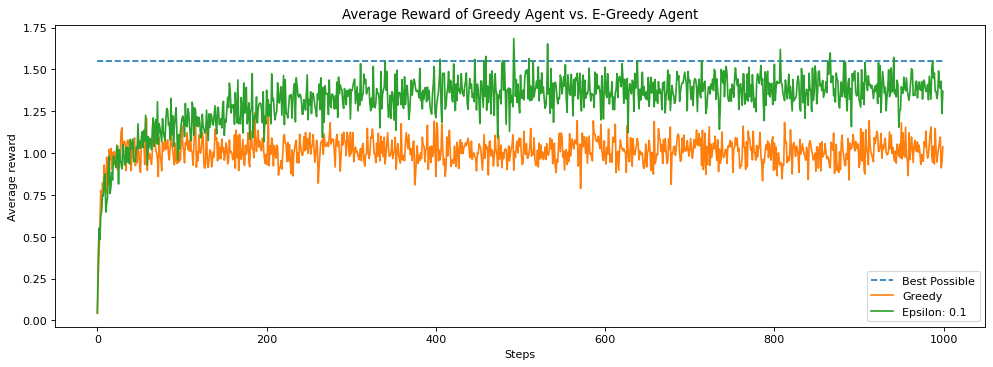

In [12]:
#epsilon vs greedy
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env_Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_rewards = np.zeros((num_runs, num_steps))

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        all_rewards[run, i] = reward

# take the mean over runs
scores = np.mean(all_rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(scores)
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

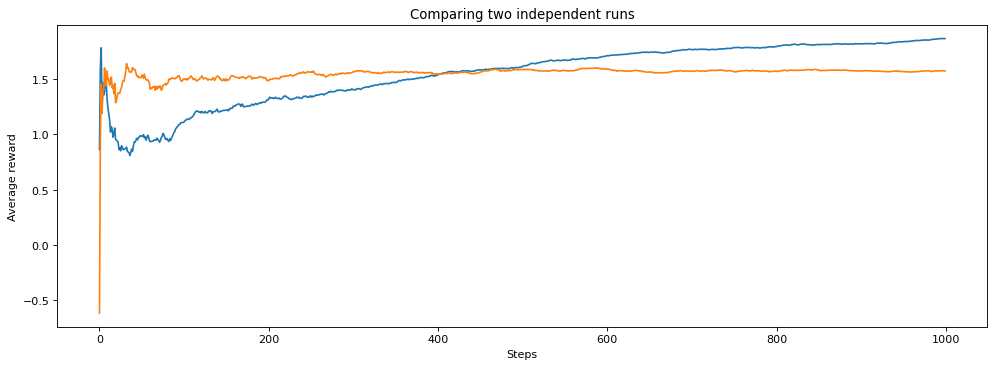

In [13]:
agent = EpsilonGreedyAgent
env = ten_arm_env_Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

# Effect of Step-Size in Epsilon greedy agent

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.42it/s]


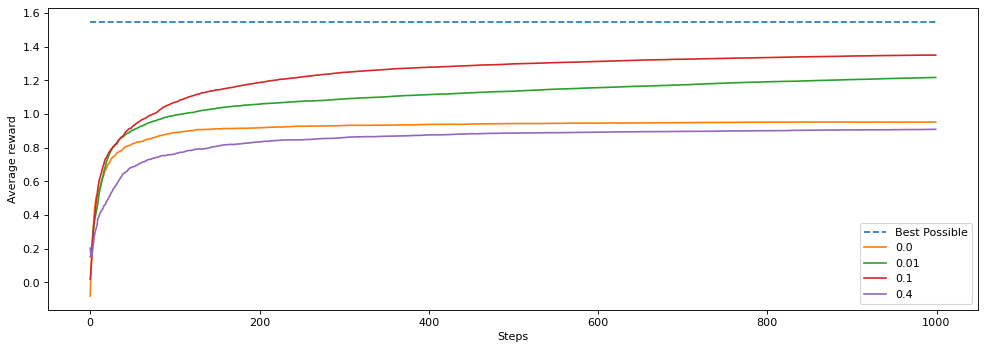

In [14]:
#effect of step size
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

# Agent Sub-Class: Epsilon Greedy Agent with Constant StepSize

In [15]:
class EpsilonGreedyAgentConstantStepsize(Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : An int of the action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action] = self.q_values[self.last_action] + (reward - self.q_values[self.last_action])*self.step_size 

        
        # Choose action using epsilon greedy.
        x = np.random.random()
        if(x < self.epsilon):
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        
        self.last_action = current_action
        
        return current_action

# Comparing Epsilon Greedy with various stepsize parameters for Stationary Bandit

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 39.99it/s]
C:\Users\ASUS\AppData\Local\Temp/ipykernel_26572/1787704549.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


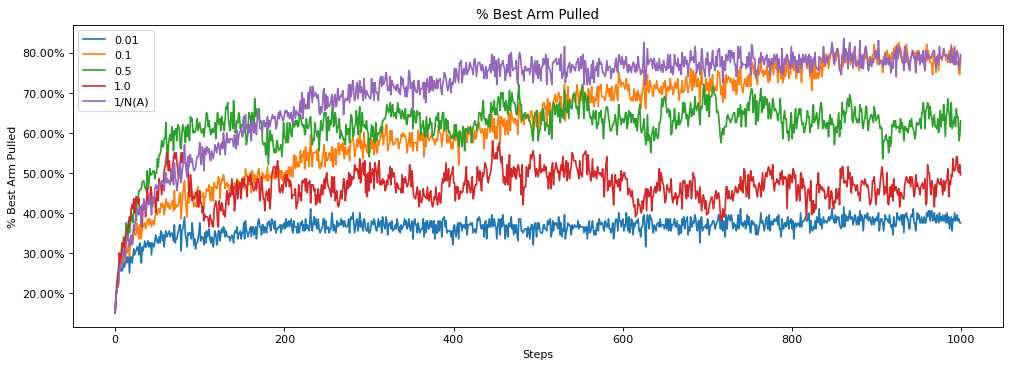

In [16]:
#for stationary values of arms of bandit
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

# Comparing for non-stationary bandit

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 22.74it/s]


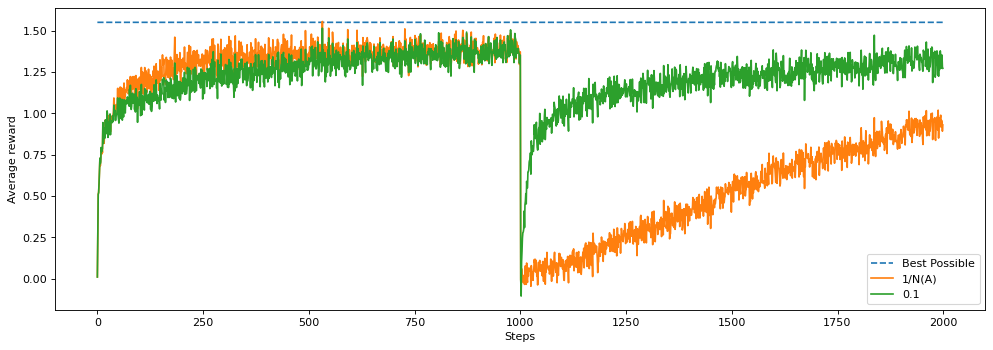

In [17]:
#For non-stationary bandit arms
epsilon = 0.1
num_steps = 2000
num_runs = 500
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    rewards = np.zeros((num_runs, num_steps))
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            rewards[run, i] = reward
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        
    plt.plot(np.mean(rewards, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()